# Project summary 
Project : Customer Retention analysis
Data : 
- First Order Table
    - mem_no : Customer ID 
    - first_ord_dt : First order date 
    - is_promotion : Category for promotion 
    
- Last Order Table
    - mem_no : Customer ID 
    - ord_no : order id
    - ord_nt : order date 

- Attribute domain
    - Customer : 2000 // len(df_cohort['mem_no'].unique())
    - Order : 16144 // len(df_cohort['ord_no'].unique())
    - period : '2023-01-01'~'2023-03-31' // (df_cohort['ord_dt'].min())

- Hypothesis : Retention differs from promotion
- Test method : Cohort-retention  

In [1]:
# SQL Alchemy load 
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import pandas as pd 
from sqlalchemy import text


server="DESKTOP-CK9O8A7\SQLEXPRESS"
database="test"
driver="ODBC Driver 17 for SQL Server"

conn_str=f'mssql+pyodbc://{server}/{database}?driver={driver}'

engine = create_engine(conn_str)

In [3]:
# Raw data load
df_cohort=pd.read_csv('order_master_cohort.csv')
df_order=pd.read_csv('first_ord_table.csv')

In [5]:
# EDA1
print(df_cohort) 
print(df_cohort.columns) 
print(df_cohort.dtypes)


       mem_no  ord_no      ord_dt
0         800   10000  2023-01-08
1         800   10001  2023-02-11
2         800   10002  2023-03-11
3         800   10003  2023-03-06
4         929   10004  2023-02-26
...       ...     ...         ...
16139    1998   26139  2023-03-31
16140    1998   26140  2023-02-27
16141    1998   26141  2023-01-13
16142    1998   26142  2023-01-26
16143    1998   26143  2023-01-18

[16144 rows x 3 columns]
Index(['mem_no', 'ord_no', 'ord_dt'], dtype='object')
mem_no     int64
ord_no     int64
ord_dt    object
dtype: object


In [7]:
# EDA2
print(df_order) 
print(df_order.columns) 
print(df_order.dtypes)


      mem_no first_ord_dt  is_promotion
0          1   2023-01-13             0
1          2   2023-01-23             0
2          3   2023-01-08             0
3          4   2023-01-24             0
4          5   2023-01-22             0
...      ...          ...           ...
1995    1996   2023-01-13             1
1996    1997   2023-01-08             1
1997    1998   2023-01-26             1
1998    1999   2023-01-06             1
1999    2000   2023-01-31             1

[2000 rows x 3 columns]
Index(['mem_no', 'first_ord_dt', 'is_promotion'], dtype='object')
mem_no           int64
first_ord_dt    object
is_promotion     int64
dtype: object


# SQL Case 

In [8]:
# load to DB.
df_cohort.to_sql('order_master_cohort',engine,if_exists='append',index=False)
df_order.to_sql('first_ord_table',engine,if_exists='append',index=False)


602

In [9]:
# check first_ord_table
query = '''
	select *
	from first_ord_table
'''  
df = pd.read_sql(query, engine)
df.head(5)

,mem_no,first_ord_dt,is_promotion
0,1,2023-01-13,0
1,2,2023-01-23,0
2,3,2023-01-08,0
3,4,2023-01-24,0
4,5,2023-01-22,0


In [10]:
# check order_master_cohort
query = '''
	select *
	from order_master_cohort
'''  
df = pd.read_sql(query, engine)
df.head(5)

,mem_no,ord_no,ord_dt
0,800,10000,2023-01-08
1,800,10001,2023-02-11
2,800,10002,2023-03-11
3,800,10003,2023-03-06
4,929,10004,2023-02-26


In [11]:
# check join table
join_query='''
select * 
from first_ord_table fot
left join order_master_cohort omc on fot.mem_no=omc.mem_no

'''
df = pd.read_sql(join_query, engine)
df

,mem_no,first_ord_dt,is_promotion,mem_no,ord_no,ord_dt
0,800,2023-01-08,0,800,10000,2023-01-08
1,800,2023-01-08,0,800,10001,2023-02-11
2,800,2023-01-08,0,800,10002,2023-03-11
3,800,2023-01-08,0,800,10003,2023-03-06
4,929,2023-01-02,0,929,10004,2023-02-26


In [ ]:
-- SQL Server 
SELECT 
    DISTINCT fot.mem_no,
    is_promotion,
    CASE 
        WHEN ord_dt = first_ord_dt THEN 0
        WHEN ord_dt > first_ord_dt AND ord_dt <= DATEADD(day, 7, first_ord_dt) THEN 1
        WHEN ord_dt > DATEADD(day, 7, first_ord_dt) AND ord_dt <= DATEADD(day, 14, first_ord_dt) THEN 2
        WHEN ord_dt > DATEADD(day, 14, first_ord_dt) AND ord_dt <= DATEADD(day, 21, first_ord_dt) THEN 3
        WHEN ord_dt > DATEADD(day, 21, first_ord_dt) AND ord_dt <= DATEADD(day, 28, first_ord_dt) THEN 4
        ELSE NULL 
    END AS week_range
FROM first_ord_table fot
LEFT JOIN order_master_cohort omc ON fot.mem_no = omc.mem_no;


In [13]:
# combined data frame for cohort
cohort_query='''
SELECT 
    DISTINCT fot.mem_no,
    is_promotion,
    CASE 
        WHEN ord_dt = first_ord_dt THEN 0
        WHEN ord_dt > first_ord_dt AND ord_dt <= DATEADD(day, 7, first_ord_dt) THEN 1
        WHEN ord_dt > DATEADD(day, 7, first_ord_dt) AND ord_dt <= DATEADD(day, 14, first_ord_dt) THEN 2
        WHEN ord_dt > DATEADD(day, 14, first_ord_dt) AND ord_dt <= DATEADD(day, 21, first_ord_dt) THEN 3
        WHEN ord_dt > DATEADD(day, 21, first_ord_dt) AND ord_dt <= DATEADD(day, 28, first_ord_dt) THEN 4
        ELSE NULL 
    END AS week_range
FROM first_ord_table fot
LEFT JOIN order_master_cohort omc ON fot.mem_no = omc.mem_no;

'''
df = pd.read_sql(cohort_query, engine)
df

,mem_no,is_promotion,week_range
0,1066,1,0.0
1,1514,1,NaN
2,1377,1,0.0
3,1301,1,0.0
4,1840,1,3.0
...,...,...,...
5827,483,0,NaN
5828,1172,1,NaN
5829,1963,1,1.0
5830,1635,1,1.0


In [ ]:
-- SQL Server
WITH T1 AS (
    SELECT 
        DISTINCT fot.mem_no,
        is_promotion,
        CASE 
            WHEN ord_dt = first_ord_dt THEN 0
            WHEN ord_dt > first_ord_dt AND ord_dt <= DATEADD(day, 7, first_ord_dt) THEN 1
            WHEN ord_dt > DATEADD(day, 7, first_ord_dt) AND ord_dt <= DATEADD(day, 14, first_ord_dt) THEN 2
            WHEN ord_dt > DATEADD(day, 14, first_ord_dt) AND ord_dt <= DATEADD(day, 21, first_ord_dt) THEN 3
            WHEN ord_dt > DATEADD(day, 21, first_ord_dt) AND ord_dt <= DATEADD(day, 28, first_ord_dt) THEN 4
            ELSE NULL 
        END AS week_number
    FROM first_ord_table fot
    LEFT JOIN order_master_cohort omc ON fot.mem_no = omc.mem_no
),
T2 AS (
    SELECT 
        is_promotion,
        mem_no,
        week_number,
        row_number() OVER (PARTITION BY mem_no ORDER BY week_number) AS seq
    FROM T1
    WHERE week_number IS NOT NULL 
)
SELECT 
    is_promotion,
    CASE
        WHEN week_number = 0 THEN '1.w-0'
        WHEN week_number = 1 AND seq = 2 THEN '2.w-1'
        WHEN week_number = 2 AND seq = 3 THEN '3.w-2'
        WHEN week_number = 3 AND seq = 4 THEN '4.w-3'
        WHEN week_number = 4 AND seq = 5 THEN '5.w-4' 
    END AS week_range,
    COUNT(mem_no) AS mem_cnt
FROM T2
group by is_promotion, week_number, seq
order by is_promotion, week_range, mem_cnt

In [47]:
cohort_query='''
-- SQL Server
WITH T1 AS (
    SELECT 
        DISTINCT fot.mem_no,
        is_promotion,
        CASE 
            WHEN ord_dt = first_ord_dt THEN 0
            WHEN ord_dt > first_ord_dt AND ord_dt <= DATEADD(day, 7, first_ord_dt) THEN 1
            WHEN ord_dt > DATEADD(day, 7, first_ord_dt) AND ord_dt <= DATEADD(day, 14, first_ord_dt) THEN 2
            WHEN ord_dt > DATEADD(day, 14, first_ord_dt) AND ord_dt <= DATEADD(day, 21, first_ord_dt) THEN 3
            WHEN ord_dt > DATEADD(day, 21, first_ord_dt) AND ord_dt <= DATEADD(day, 28, first_ord_dt) THEN 4
            ELSE NULL 
        END AS week_number
    FROM first_ord_table fot
    LEFT JOIN order_master_cohort omc ON fot.mem_no = omc.mem_no
),
T2 AS (
    SELECT 
        is_promotion,
        mem_no,
        week_number,
        row_number() OVER (PARTITION BY mem_no ORDER BY week_number) AS seq
    FROM T1
    WHERE week_number IS NOT NULL 
)
SELECT 
    is_promotion,
    CASE
        WHEN week_number = 0 THEN '1.w-0'
        WHEN week_number = 1 AND seq = 2 THEN '2.w-1'
        WHEN week_number = 2 AND seq = 3 THEN '3.w-2'
        WHEN week_number = 3 AND seq = 4 THEN '4.w-3'
        WHEN week_number = 4 AND seq = 5 THEN '5.w-4' 
    END AS week_range,
    COUNT(mem_no) AS mem_cnt
FROM T2
group by is_promotion, week_number, seq
order by is_promotion, week_range, mem_cnt

'''
df = pd.read_sql(cohort_query, engine)
df

,is_promotion,week_range,mem_cnt
0,0,None,50
1,0,None,68
2,0,None,70
3,0,None,74
4,0,None,77
5,0,None,125
6,0,1.w-0,1000
7,0,2.w-1,239
8,0,3.w-2,104
9,0,4.w-3,59


In [48]:
# Copy original DF
backup_df=df
# df=backup_df

In [51]:
# Cohort Table 
df=df[df['week_range'].notnull()]
df['retention']=df['mem_cnt']/1000
df['week_range']=df['week_range'].str[2:5]
df



,is_promotion,week_range,mem_cnt,retention
6,0,w-0,1000,1.000
7,0,w-1,239,0.239
8,0,w-2,104,0.104
9,0,w-3,59,0.059
10,0,w-4,45,0.045
17,1,w-0,1000,1.000
18,1,w-1,440,0.440
19,1,w-2,266,0.266
20,1,w-3,198,0.198
21,1,w-4,155,0.155


In [52]:
# Divide by group
promotion_0=df[df['is_promotion']==0]
promotion_1=df[df['is_promotion']==1]
promotion_1

,is_promotion,week_range,mem_cnt,retention
17,1,w-0,1000,1.000
18,1,w-1,440,0.440
19,1,w-2,266,0.266
20,1,w-3,198,0.198
21,1,w-4,155,0.155


In [80]:
# table merge

mg1=promotion_1[['week_range','retention']]
mg0=promotion_0[['week_range','retention']]

merged_df = pd.merge(mg1, mg0, on='week_range', how='inner')
merged_df['gap']=merged_df['retention_x']-merged_df['retention_y']

merged_df.drop(columns=['retention_x','retention_y'],inplace=True)

merged_df

,week_range,gap
0,w-0,0.000
1,w-1,0.201
2,w-2,0.162
3,w-3,0.139
4,w-4,0.110


Text(0.5, 1.0, 'Retention by promotion')

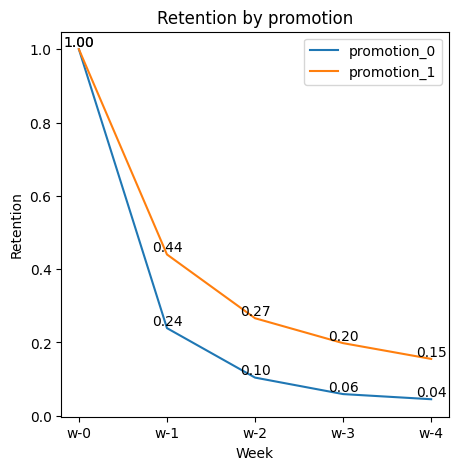

In [58]:
# data visualization 
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5,5))
ax=fig.add_subplot()

ax.plot(promotion_0['week_range'],promotion_0['retention'],label='promotion_0')
ax.plot(promotion_1['week_range'],promotion_1['retention'],label='promotion_1')
ax.legend()

# text data label
for x, y in zip(promotion_0['week_range'], promotion_0['retention']):
    ax.text(x, y, f'{y:.2f}', ha='center', va='bottom')
for x, y in zip(promotion_1['week_range'], promotion_1['retention']):
    ax.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.xlabel('Week')
plt.ylabel('Retention')
plt.title('Retention by promotion')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Retention gap %p')

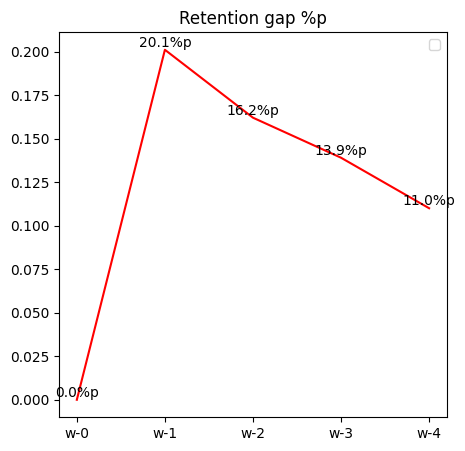

In [90]:
fig = plt.figure(figsize=(5,5))
ax=fig.add_subplot()

ax.plot(merged_df['week_range'],merged_df['gap'],color="Red")
ax.legend()
for x, y in zip(merged_df['week_range'], merged_df['gap']):
    # ax.text(x, y, f'{y:.2f}', ha='center', va='bottom')
    # ax.text(x, y, f'{y:.2%}', ha='center', va='bottom')
    ax.text(x, y, f'{y:.1%}p', ha='center', va='bottom')

plt.title('Retention gap %p')

# Conclusion
- Promotion has significant impact on retention rate